# Road towards Anticipatory Learning Classifier Systems

History of LCS, XCS, ACS, ACS2, YACS, others

In [1]:
import sys

# put custom scripts to module path
from copy import copy

sys.path.append('../../..')

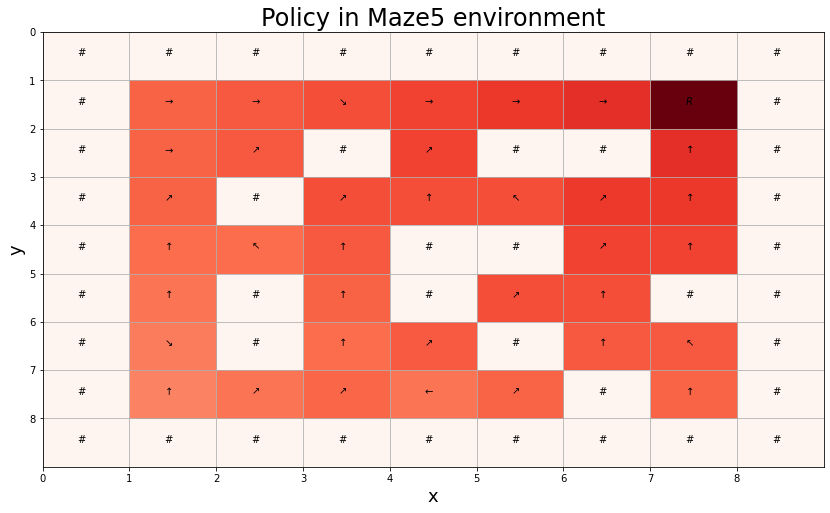

In [65]:
import gym
import gym_maze  # noqa: F401

import pathlib

import numpy as np
import matplotlib.pyplot as plt

from lcs import Perception
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList, Classifier
from lcs.metrics import population_metrics

from typing import Optional, Tuple

from src.decorators import get_from_cache_or_run

cache_dir = f'{pathlib.Path().absolute()}/cache'
plot_dir = f'{pathlib.Path().absolute()}/plots'

plt.ioff()  # turn off interactive plotting
PLOT_DPI = 200

def maze_metrics(agent, env):
    metrics = {}
    metrics.update(population_metrics(agent.population, env))
    return metrics

acs2_base_params = {
    'classifier_length': 8,
    'number_of_possible_actions': 8,
    'biased_exploration': 0,
    'metrics_trial_frequency': 1,
    'user_metrics_collector_fcn': maze_metrics
}

def run_acs2_explore_exploit(env, explore_trials, exploit_trials, **config):
    cfg = Configuration(**config)

    # explore phase
    agent = ACS2(cfg)
    metrics_explore = agent.explore(env, explore_trials)

    # exploit phase
    agent_exploit = ACS2(cfg, copy(agent.population))
    metrics_exploit = agent_exploit.exploit(env, exploit_trials)

    return (agent, metrics_explore), (agent_exploit, metrics_exploit)

def find_best_classifier(population: ClassifiersList, situation: Perception) -> Optional[Classifier]:
    match_set = population.form_match_set(situation)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]

    if len(anticipated_change_cls) > 0:
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)

    return None

def build_fitness_and_action_matrices(env, population) -> Tuple:
    original = env.env.maze.matrix

    fitness = original.copy()
    action = original.copy().astype(str)

    action_lookup = {
        0: u'↑', 1: u'↗', 2: u'→', 3: u'↘',
        4: u'↓', 5: u'↙', 6: u'←', 7: u'↖'
    }

    for index, x in np.ndenumerate(original):
        if x == 0:  # path
            perception = env.env.maze.perception(index)
            best_cl = find_best_classifier(population, perception)

            if best_cl:
                fitness[index] = best_cl.fitness
                action[index] = action_lookup[best_cl.action]
            else:
                fitness[index] = -1
                action[index] = '?'

        if x == 1:  # wall
            fitness[index] = 0
            action[index] = '\#'

        if x == 9:  # reward
            # add 500 to make it more distinguishable
            fitness[index] = fitness.max() + 500
            action[index] = 'R'

    return fitness, action

def plot_policy(env, fitness_matrix, action_matrix):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))

    max_x, max_y = env.env.maze.matrix.shape

    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='nearest', cmap='Reds', aspect='auto', extent=[0, max_x, max_y, 0])

    # Add labels to each cell
    for (y, x), val in np.ndenumerate(action_matrix):
        plt.text(x + 0.4, y + 0.5, "${}$".format(val))

    ax.set_title("Policy in Maze5 environment", fontsize=24)
    ax.set_xlabel('x', fontsize=18)
    ax.set_ylabel('y', fontsize=18)
    ax.set_xlim(0, max_x)
    ax.set_ylim(max_y, 0)
    ax.set_xticks(range(0, max_x))
    ax.set_yticks(range(0, max_y))
    ax.grid(True)
    fig.savefig(f'{plot_dir}/acs2-maze5.png', dpi=PLOT_DPI)

@get_from_cache_or_run(cache_path=f'{cache_dir}/acs2_maze5.dill')
def run_acs2_in_maze5():
    env = gym.make('Maze5-v0')
    explore_phase, exploit_phase = run_acs2_explore_exploit(env, explore_trials=5000, exploit_trials=100, **acs2_base_params)
    return env, explore_phase, exploit_phase

# Run computation
env_, explore_, exploit_ = run_acs2_in_maze5()

# Plot the policy
fitness_matrix, action_matrix = build_fitness_and_action_matrices(env_, explore_[0].population)
plot_policy(env_, fitness_matrix, action_matrix)

:::{figure-md} maze5-fig
:class: full-width
<img src="plots/acs2-maze5.png">

Policy of Maze5. Saturation of red color reflects the best classifier fitness value.
:::

---

**Software packages used**

In [ ]:
import session_info
session_info.show()